In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.opt_utils import *
import h5py
import pickle
from qutip import *
import time
import tqdm
import scipy as sp
from scipy.optimize import curve_fit

In [2]:
wc_A = 4.069814 * (10**9) * 2 * np.pi  # cavity A frequency
wc_B = 6.096062 * (10**9) * 2 * np.pi  # cavity A frequency
wa =  5.325 * (10**9) * 2 * np.pi  # atom frequency
dt_A = np.abs(wc_A - wa) / (2 * np.pi)
dt_B = np.abs(wc_B - wa) / (2 * np.pi)
chi_A = 0.00215 * (10**9) * 2 * np.pi
chi_B = 0.00544 * (10**9) * 2 * np.pi
g_A = np.sqrt(chi_A * dt_A) * 2 * np.pi  # coupling strength w/ cavity A
g_B = np.sqrt(chi_B * dt_B) * 2 * np.pi  # coupling strength w/ cavity B

gamma = 333333.333        # atom dissipation rate
kappa_A = 10000       # cavity A dissipation rate
kappa_B = 10000       # cavity B dissipation rate

temp_q = 0.0        # avg number of thermal bath excitation for qubit
temp_A = 0.0        # avg number of thermal bath excitation for cavity A
temp_B = 0.0        # avg number of thermal bath excitation for cavity B

alpha = -2 * np.pi * 207.343 * 1e6  # rad.Hz

In [3]:
cavity_dims = 2

def cost_q_g(final_expect, final_state):
    return  np.power(np.abs(final_state[0]), 2)

def cost_q_e(final_expect, final_state):
    return  np.power(np.abs(final_state[cavity_dims]), 2)

def cost_qA_g1(final_expect, final_state):
    return np.power(np.abs(final_state[1][0]), 2)

In [7]:
max_segs = 20
us = 0.000001
time_start = 0.0000000
time_stop = 2 * us
init_amp = 4000000
n_steps = 501


num_drives = 1
num_elems = 1
num_cavities = 0
# cavity_dims = 8
state_sizes = [3]
state_vals = [0]
sim_options = Options()
init_freqs = [wa]
element_freqs = [wa]
drive_elem_nums = [0]
output_cost_func = cost_q_g
verbose = True
plot_trial_pulses = False

t_arr = np.linspace(time_start, time_stop, n_steps)

t_step = (time_stop - time_start) / n_steps

sim_options.store_final_state = True

sm, a_A, a_B, sx, sz = reg_ops(num_cavities + 1, cavity_dims)
a_q = destroy(state_sizes[0])

drive_freqs = np.array(element_freqs)

gammas = [gamma]
temps = [temp_q]
cops = []

# Operators used in Hamiltonian
drive_ops = [a_q.dag(), a_q]
element_ops = [a_q.dag(), a_q]
H_0 = (alpha * a_q.dag() * a_q.dag() * a_q * a_q / 2) # + (chi_A * a_A.dag() * a_A * sz)
eval_ops = [a_q.dag() * a_q]

init_state = (basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0]))  # tensor((basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0])), (basis(state_sizes[1], 0) * np.sqrt(1 - state_vals[1])) + (basis(state_sizes[1], 1) * np.sqrt(state_vals[1])))

client_args = [num_drives, drive_ops, element_freqs, H_0, init_state, t_arr, eval_ops, sim_options, output_cost_func, verbose, time_start, time_stop]

In [8]:
freqs = np.array(element_freqs)

N_segs = 51
amp_times = np.linspace(time_start, time_stop, N_segs + 1)

times = np.array([amp_times, amp_times])

100%|██████████| 26/26 [50:31<00:00, 116.58s/it]


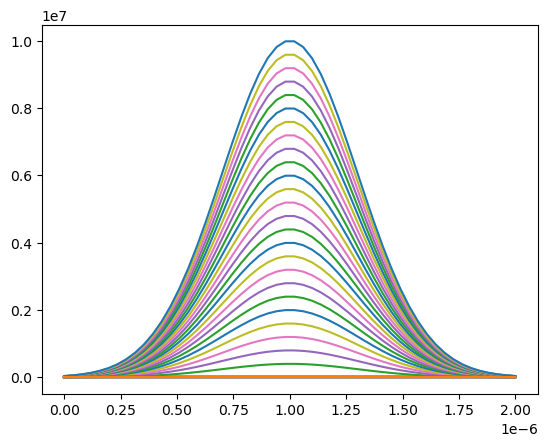

In [13]:
A_i = 0
A_f = 10000000
N_amp = 26

verbose = False

client_args = [num_drives, drive_ops, element_freqs, H_0, init_state, eval_ops, sim_options, output_cost_func, time_start, time_stop, drive_freqs, drive_elem_nums,verbose, plot_trial_pulses]

q1_pi_sigma = 0.30 * us

q1_pi_amp = 2 * 2507175

q_time = 1 * us  # fixed

A_arr = np.linspace(A_i, A_f, N_amp)

costs = []

for A in tqdm.tqdm(A_arr):
    amp_funcs = [
        [gauss_gen(A, q_time, q1_pi_sigma, 1)], 
        [zero]]
    amp_func = [func_sum(amp_funcs[i]) for i in range(len(amp_funcs))]
    
    amp_pts = np.array([amp_func[i](amp_times) for i in range(len(amp_func))])
    # print(amp_pts)
    
    for i in range(len(amp_func)):
        plt.plot(amp_times, amp_pts[i], label=f'A: {A}')
    
    client_opts = np.append(amp_pts[:, 1:-1].flatten(), times[:, 1:-1].flatten())
    
    res = sim_interp_cost_eval(client_opts, *client_args)
    costs.append(res[0][0])
    # print(f'Amp: {A}, cost: {res[0][0]}')
plt.show()

In [20]:
costs = np.array(costs)[:, 0, 0]

In [21]:
def sin_fit(x, y):
    def sin_helper(t, A, w, d, C):
        return (A * np.sin((t * w) - d)) + C
    
    min_amp = min(y)
    max_amp = max(y)
    mid_amp = (min_amp + max_amp) / 2
    disp_amp = max_amp - mid_amp
    
    p0 = [disp_amp, 6 * np.pi / (x[-1] - x[0]), np.arctan2(y[0], disp_amp), mid_amp]
    
    popt, pcorr = curve_fit(sin_helper, x, y, p0=p0)
    
    print(f'popt: {popt}')
    
    print(f'pi_amp: {round(np.pi / popt[1])}')
    
    plt.plot(x, y, label="Data")
    plt.plot(x, sin_helper(x, *popt), label="Fit")
    plt.legend()
    plt.show()

popt: [ 4.99998363e-01  1.50234131e-06 -1.57084276e+00  5.00005104e-01]
pi_amp: 2091131


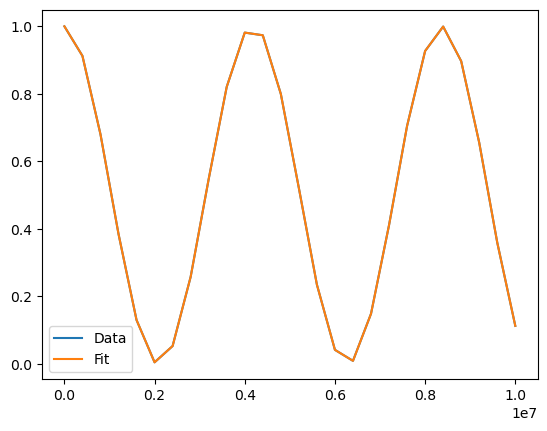

In [22]:
sin_fit(A_arr, costs)

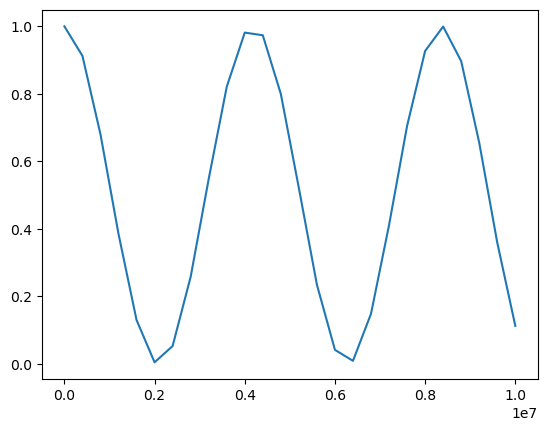

In [19]:
plt.plot(A_arr, np.array(costs)[:, 0, 0])
plt.show()